In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
data = pd.read_excel("Bank_Personal_Loan_Modelling.xlsx", sheet_name = "Data")
data.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


---
**Observations:** Our goal here is to construct a model that can identify potential customers who have higher probability of purchasing loan. Our dataset contains 12 features. Our target column is 'Personal Loan'. 

---

### Data Analysis

In [3]:
data.drop("ID", axis = 1, inplace = True)

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

X = data.loc[:, data.columns != "Personal Loan"]
y = data[["Personal Loan"]]

print("X info: \n")
X.info()
print("\n y info: \n")
y.info()

X info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIP Code            5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Securities Account  5000 non-null   int64  
 9   CD Account          5000 non-null   int64  
 10  Online              5000 non-null   int64  
 11  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 468.9 KB

 y info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 1 columns):
 #   Column         Non-Nu

---
**Observations:** All columns seem to be numeric, but the 'ZIP Code' feature is actually a categorical feature. Let's have a quick look at this particular column.

---

In [4]:
X["ZIP Code"].nunique()

467

---
**Observations:** We can deem the 'ZIP Code' column as uninformative in this case and drop it.

---

In [5]:
# Drop 'ZIP Code' column
X.drop("ZIP Code", axis = 1, inplace = True)

In [6]:
# Check number of classes in the output
y["Personal Loan"].value_counts()

Personal Loan
0    4520
1     480
Name: count, dtype: int64

---
**Observations:** There are 2 classes in the 'Personal loan' column and and the class ratio is approximately 1:10, indicating that our dataset is imbalanced.

---

In [7]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

X_train.reset_index(drop = True, inplace = True);
X_test.reset_index(drop = True, inplace = True);
y_train.reset_index(drop = True, inplace = True);
y_test.reset_index(drop = True, inplace = True);

In [8]:
# Visualize potential outliers for each feature

def plots(feature):
    fig = plt.figure(constrained_layout = True, figsize = (10, 4))
    gs = gridspec.GridSpec(nrows = 1, ncols = 4, figure = fig)

    # Plot normalized histograms, one for each value of the target variable
    ax1 = fig.add_subplot(gs[0,:3])   
    ax1.grid(False)
    sns.distplot(X_train.loc[y_train["Personal Loan"] == 0, feature],
                 kde = False, color = "teal", norm_hist = False,
                 hist_kws = dict(alpha=0.8), bins = 40,
                 label = "Not Loan Customers", ax = ax1);
    
    sns.distplot(X_train.loc[y_train["Personal Loan"] == 1, feature],
                 kde = False, color = "firebrick", norm_hist = False,
                 hist_kws = dict(alpha=0.6), bins = 40,
                 label = "Loan Customers", ax = ax1);
    
    # Box plot of the same feature to identify outliers
    ax2 = fig.add_subplot(gs[0, 3])   
    ax2.grid(False)
    sns.boxplot(X_train[feature], orient = "v", color = "darkorange",
                width = 0.2, ax = ax2);
    
    ax1.legend(loc = "upper right");

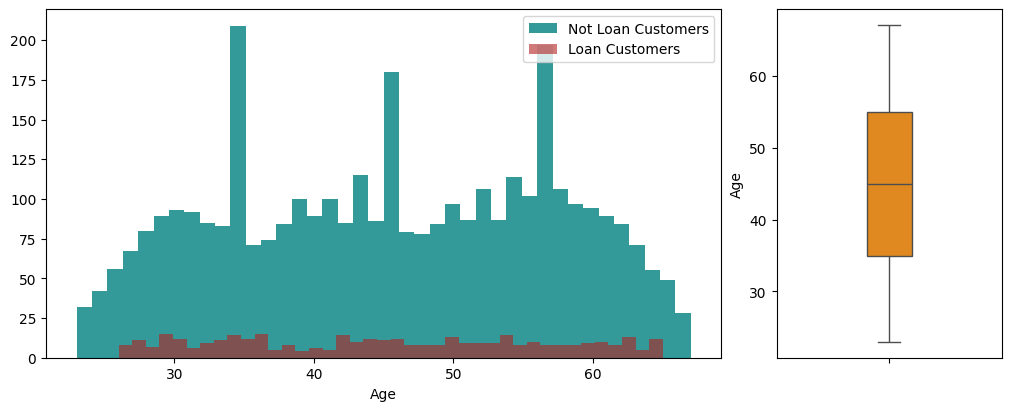

In [9]:
# Plot 'Age' feature
plots("Age")

---
**Observations:** There aren't any outliers for the 'Age' feature.

---

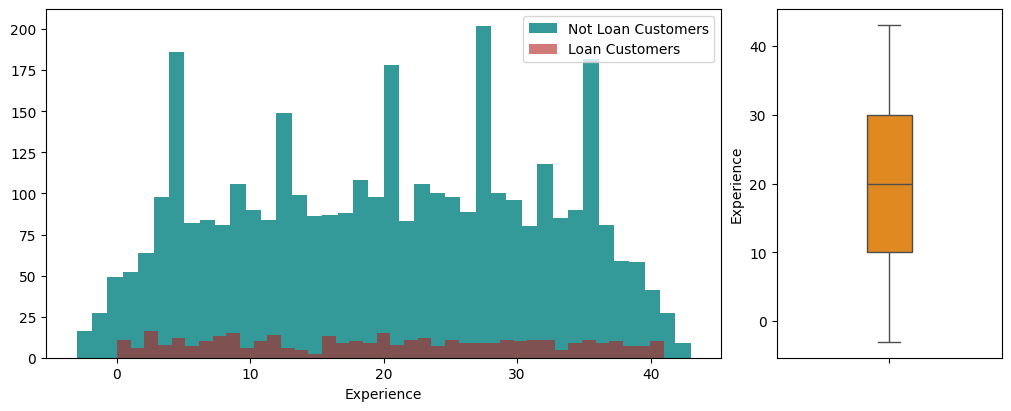

In [10]:
# Plot 'Experience' feature
plots("Experience")

---
**Observations:** There aren't any outliers for the 'Experience' feature either.

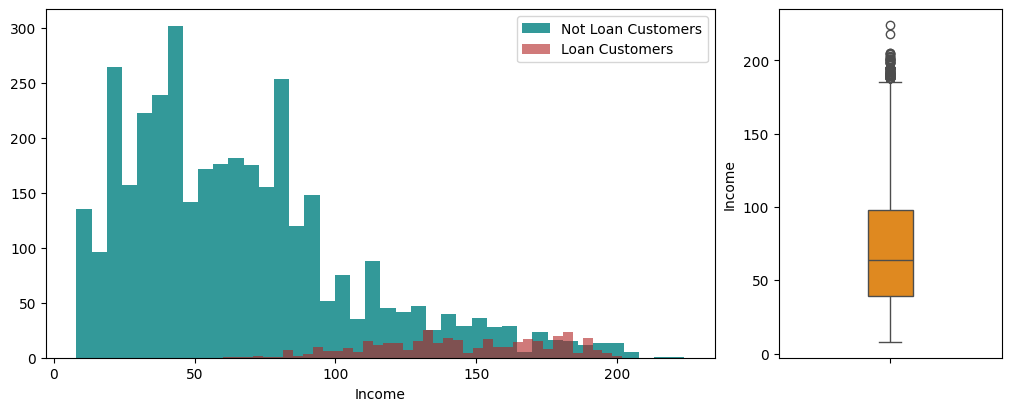

In [11]:
# Plot 'Income' feature
plots("Income")

---
**Observations:** The distribution of the 'Income' feature is highly skewed. The samples higher than UW will be replaced with the 95th quantile.

---

In [12]:
Q1 = X_train["Income"].quantile(0.25)
Q3 = X_train["Income"].quantile(0.75)
q95th = X_train["Income"].quantile(0.95)
IQR = Q3 - Q1
UW = Q3 + 1.5 * IQR

X_train["Income"] = np.where(X_train["Income"] > UW, q95th, X_train["Income"])

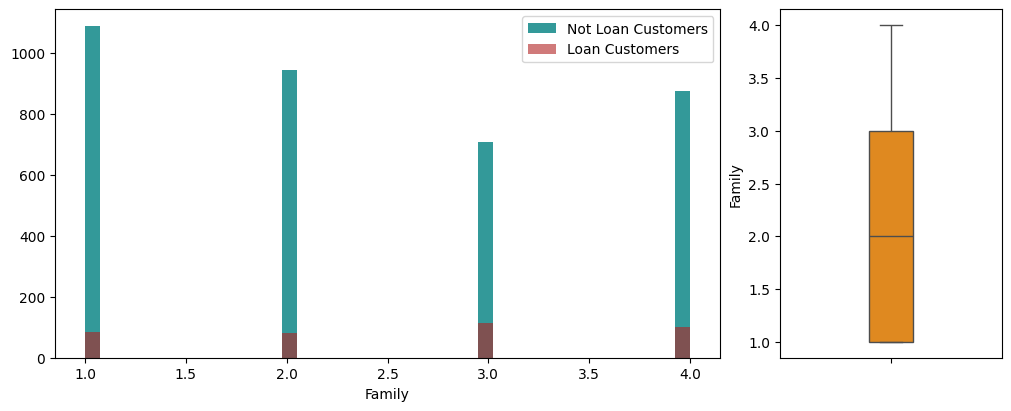

In [13]:
# Plot 'Family' feature
plots("Family")

---
**Observations:** The 'Family' feature takes four discrete values. It's an ordinal categorical variable and there aren't any outliers.

---

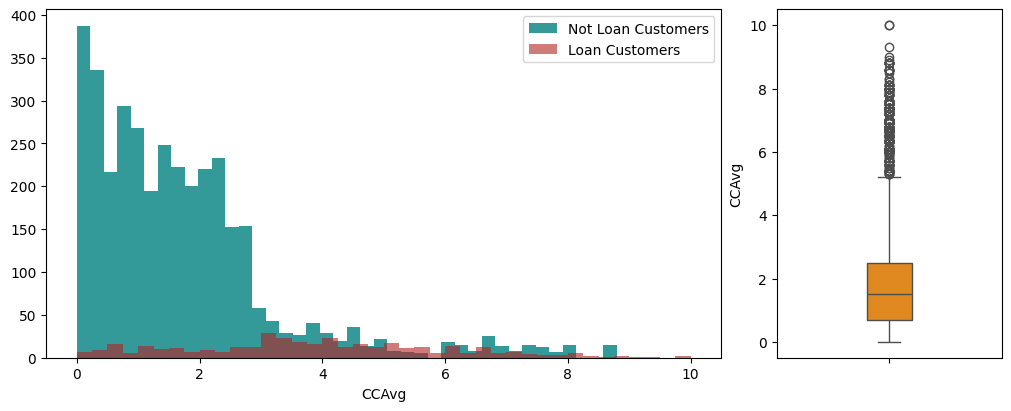

In [14]:
# Plot 'CCAvg' feature
plots("CCAvg")

---
**Observations:** The distribution of the 'CCAvg' feature is highly skewed too. The samples higher than UW will thus be replaced with 95th quantile.

---

In [15]:
Q1 = X_train["CCAvg"].quantile(0.25)
Q3 = X_train["CCAvg"].quantile(0.75)
q95th = X_train["CCAvg"].quantile(0.95)
IQR = Q3 - Q1
UW = Q3 + 1.5 * IQR

X_train["CCAvg"] = np.where(X_train["CCAvg"] > UW, q95th, X_train["CCAvg"])

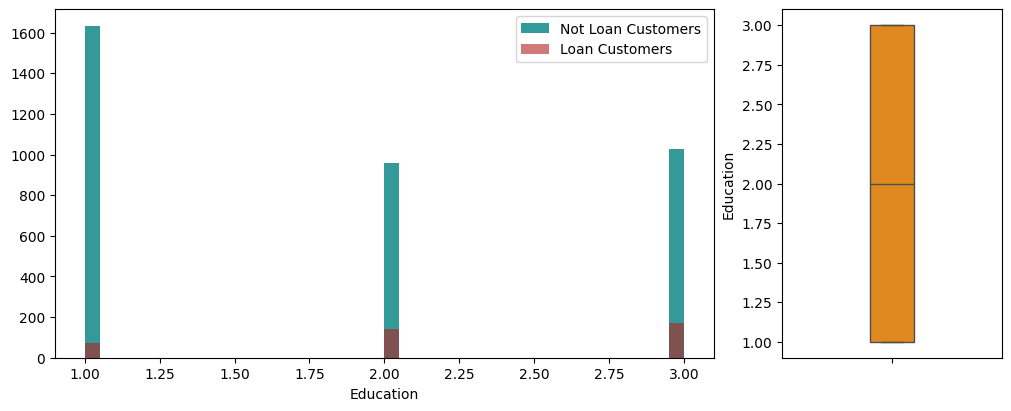

In [16]:
# Plot 'Education' feature
plots("Education")

---
**Observations:** There aren't any outliers for the 'Education' feature. It's also a categorical feature already converted to integer. In this case, integer encoding is suitable beacuse there is an ordinal relationship among education levels.

---

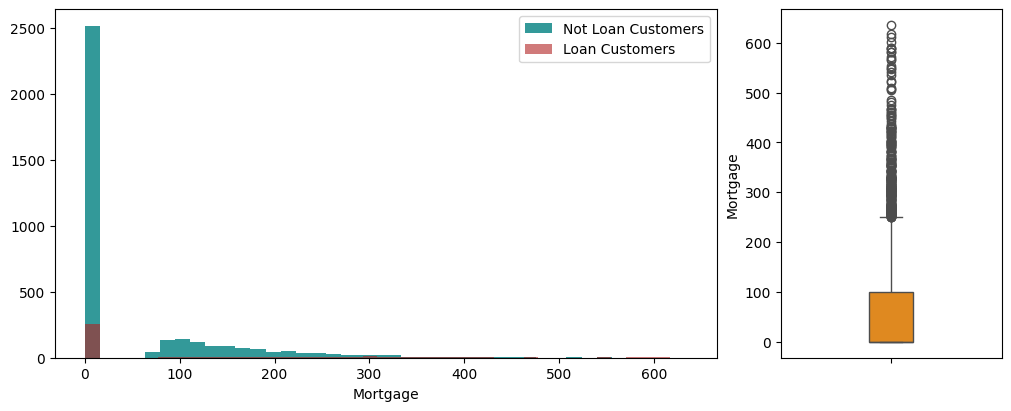

In [17]:
# Plot 'Mortgage' feature
plots("Mortgage")

---
**Observations:** A lot of customers doesn't have mortgage and the right side of the distribution is almost flat. We can construct an ordinal categorical feature 'Mortgage_Int' using Mortgage feature. Then we drop 'Mortgage' feature. We apply the same procedure to also X_test.

---

In [18]:
X_train["Mortgage_Int"] = pd.cut(X_train["Mortgage"],
                                bins = [0, 100, 200, 300, 400, 500, 600, 700],
                                labels = [0, 1, 2, 3, 4, 5, 6],
                                include_lowest = True)

X_train.drop("Mortgage", axis = 1, inplace = True)

X_test["Mortgage_Int"] = pd.cut(X_test["Mortgage"],
                                bins = [0, 100, 200, 300, 400, 500, 600, 700],
                                labels = [0, 1, 2, 3, 4, 5, 6],
                                include_lowest = True)

X_test.drop("Mortgage", axis = 1, inplace = True)

---
**Observations:** The following features are binary categorical features. Therefore there is no need to make and outlier analysis for these features.

---

In [19]:
# Quick analysis of the 'Securities Account' feature
X_train["Securities Account"].value_counts()

Securities Account
0    3589
1     411
Name: count, dtype: int64

In [20]:
# Quick analysis of the 'CD Account' feature
X_train["CD Account"].value_counts()

CD Account
0    3767
1     233
Name: count, dtype: int64

In [21]:
# Quick analysis of the 'Online' feature
X_train["Online"].value_counts()

Online
1    2354
0    1646
Name: count, dtype: int64

In [22]:
X_train["CreditCard"].value_counts()

CreditCard
0    2816
1    1184
Name: count, dtype: int64

### Data Preprocessing

In [23]:
# Input features are standardized to increase the learning performance. 
# The aim is to transform each feature to have mean of 0 and standard deviation of 1.

feature_names = X_train.columns
scaler = StandardScaler()

# fit to X_train
scaler.fit(X_train)

# transform X_train
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns = feature_names)

# transform X_test
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = feature_names)

---
**Observations:** We can now inspect the potential linear correlations between features, as well as those between features and the target variable.

---

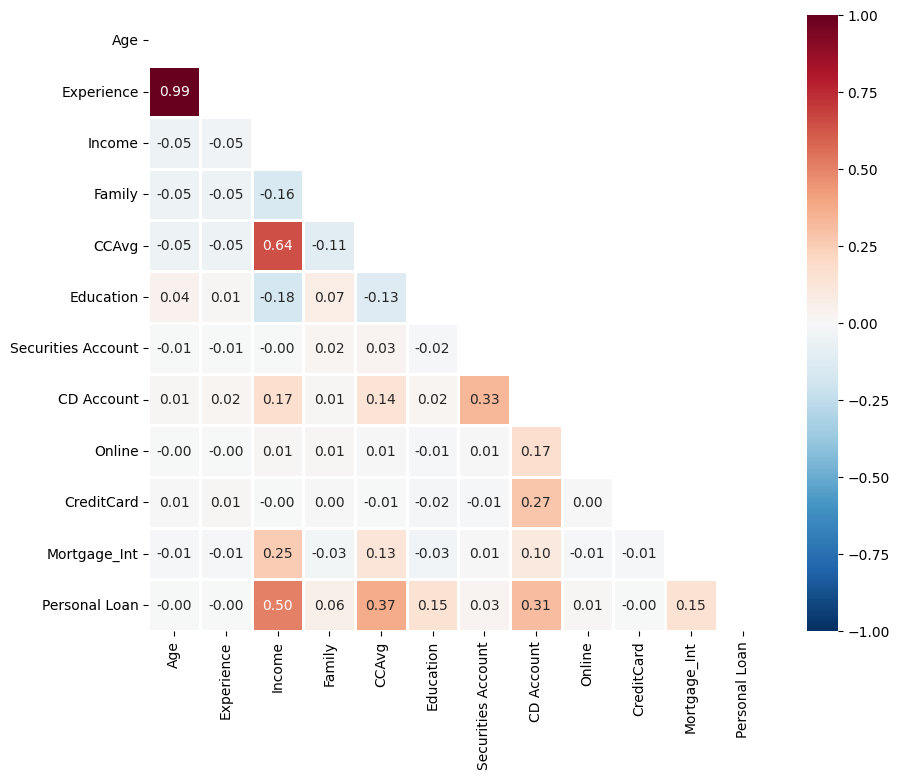

In [24]:
# Plot heatmap
np.bool = np.bool_
corr_matrix = pd.concat([X_train, y_train], axis = 1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype = np.bool))

plt.figure(figsize = (10,8))
sns.heatmap(corr_matrix, annot = True, fmt = ".2f", vmin = -1, vmax = 1, linewidth = 1, center = 0, mask = mask, cmap = "RdBu_r");

---
**Observations:** The 'Age' and 'Experience' features have very high correlation (0.99). It is also intuitively understandable that experience increases as age increases. Correlated features degrade the learning performance and causes instability on the models. We can thus drop the 'Experience' feature from both X_train and X_test.

---

In [25]:
X_train.drop("Experience", axis = 1, inplace = True)
X_test.drop("Experience", axis = 1, inplace = True)

---
### Build Model


In [26]:
# Convert dataframes to numpy arrays
np_X_train = X_train.values
np_y_train = y_train.values.ravel()
np_X_test = X_test.values
np_y_test = y_test.values.ravel()

# Create stratified 5 fold
skf_cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 0)
vec_X = []
vec_Y = []

# Iterate over each split
for train_ind, test_ind in skf_cv.split(np_X_train, np_y_train):

    # Get train and test set for this split
    train_folds_X, test_fold_X = np_X_train[train_ind], np_X_train[test_ind]
    train_folds_Y, test_fold_Y = np_y_train[train_ind], np_y_train[test_ind]
    
    # Temporary base learners
    cls_1t = LogisticRegression()
    cls_2t = DecisionTreeClassifier(random_state = 0)
    
    # Fit cls_1t on train_folds_X and predict on test_fold_X 
    cls_1t.fit(train_folds_X, train_folds_Y)
    pred_proba_1 = cls_1t.predict_proba(test_fold_X)[:,1]
    
    # Fit cls_2t on train_folds_X and predict on test_fold_X 
    cls_2t.fit(train_folds_X, train_folds_Y)
    pred_proba_2 = cls_2t.predict_proba(test_fold_X)[:,1]

    vec_X.extend(np.concatenate((pred_proba_1.reshape(-1,1), pred_proba_2.reshape(-1,1)), axis = 1))
    vec_Y.extend(test_fold_Y)
    
meta_X = np.array(vec_X)
meta_Y = np.array(vec_Y)

---
**Observations:** Base learners (LogisticRegression and DecisionTreeClassifier) are now trained on the whole training data, np_X_train and np_y_train.

---

In [27]:
# Base Learners
cls_1 = LogisticRegression()
cls_2 = DecisionTreeClassifier(random_state = 0)

# Fit cls_1 on X_train
cls_1.fit(np_X_train, np_y_train)

# Fit cls_2 on X_train
cls_2.fit(np_X_train, np_y_train);

---
**Observations:** Base learners are evaluated on np_X_test. Their classification reports are printed.

---

In [28]:
pred_1_X_test = cls_1.predict(np_X_test)
print("Classification report for base learner 1 (Logistic Regression) \n")
print(classification_report(np_y_test, pred_1_X_test, digits = 4, target_names = ["Not Loan Customers", "Loan Customers"]))

pred_2_X_test = cls_2.predict(np_X_test)
print("\n\n Classification report for base learner 2 (Decision Tree) \n")
print(classification_report(np_y_test, pred_2_X_test, digits = 4, target_names = ["Not Loan Customers", "Loan Customers"]))

Classification report for base learner 1 (Logistic Regression) 

                    precision    recall  f1-score   support

Not Loan Customers     0.9651    0.9801    0.9726       904
    Loan Customers     0.7805    0.6667    0.7191        96

          accuracy                         0.9500      1000
         macro avg     0.8728    0.8234    0.8458      1000
      weighted avg     0.9474    0.9500    0.9482      1000



 Classification report for base learner 2 (Decision Tree) 

                    precision    recall  f1-score   support

Not Loan Customers     0.9912    0.9945    0.9928       904
    Loan Customers     0.9462    0.9167    0.9312        96

          accuracy                         0.9870      1000
         macro avg     0.9687    0.9556    0.9620      1000
      weighted avg     0.9869    0.9870    0.9869      1000



---
**Observations:** XGBoost Classifier is a gradient boosting ensemble that in our case has 6 sequential estimators. So, we use an ensemble as the meta learner of our stacking ensemble.

---

In [29]:
meta = xgb.XGBClassifier(base_score = 0.5, booster = "gbtree", colsample_bylevel = 1, colsample_bynode = 1,
                         colsample_bytree = 1, gamma = 10, gpu_id = -1, learning_rate = 0.1, max_delta_step = 0,
                         max_depth = 4, n_estimators = 6, n_jobs = 0, random_state = 0, subsample = 1)

meta.fit(meta_X, meta_Y);

---
**Observations:** We process np_X_test with our base learners. Then, we feed their outputs to the meta learner and evaluate its output. Finally classification report of Stacking Ensemble is printed.

---

In [30]:
prob_1_X_test = cls_1.predict_proba(np_X_test)[:,1]
prob_2_X_test = cls_2.predict_proba(np_X_test)[:,1]

level_1_in_X = np.concatenate((prob_1_X_test.reshape(-1,1),
                               prob_2_X_test.reshape(-1,1)), axis = 1)

stacking_pred = meta.predict(level_1_in_X)

print("Classification report for Stacking Ensemble \n")
print(classification_report(np_y_test, stacking_pred, digits = 4, target_names = ["Not Loan Customers", "Loan Customers"]))

Classification report for Stacking Ensemble 

                    precision    recall  f1-score   support

Not Loan Customers     0.9901    0.9967    0.9934       904
    Loan Customers     0.9667    0.9062    0.9355        96

          accuracy                         0.9880      1000
         macro avg     0.9784    0.9515    0.9644      1000
      weighted avg     0.9879    0.9880    0.9878      1000



---
**Conclusion:** Performance of the base learners were already very high, with the Decision Tree model getting an accuracy score of 0.9880. But if we look at the precision scores for instance, the meta learner still has a positive effect with an overall precision of 0.9890 for the customers without a loan, and 0.9773 for those who do have a loan.

We can thus conclude that even though one of the base learners had exceptional results, we were able to get even better scores with the meta learner.

---